# **Llama-3.1-8B-Classification, FFN LoRa**
## **Classification of validation data; 2 Labels as scale**



In [1]:
!pip install huggingface_hub
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install --upgrade wandb
!pip install adapter-transformers

  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached hf_xet-1.1.5-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (879 bytes)
Using cached huggingface_hub-0.33.2-py3-none-any.whl (515 kB)
Using cached hf_xet-1.1.5-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadat

In [ ]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools 
from tqdm import tqdm
import bitsandbytes as bnb
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer,
                        AutoModel,
                        AutoConfig,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)

from sklearn.utils import resample


from peft import PeftModel
from huggingface_hub import login
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, f1_score, roc_curve, auc, RocCurveDisplay


In [3]:

os.getcwd()

'/home/jovyan/llama_final/Validation'

## **Authenticate for Hugging Face**

In [3]:
# Hugging face access

with open("../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

In [4]:
torch.cuda.empty_cache()
torch.cuda.is_available()
#torch.cuda.device_count()

True

In [5]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## **Reimport Pretrained Model**

In [7]:
# file paths
base_model = "meta-llama/Llama-3.1-8B" 
finetuned_path = "../Classification/two_labels/attention_FFN_LoRa/final_Llama_3.1_8B_saved_model_2labels_scale_FFN"

data_path = "data/validation_sample_small.csv"

output_path = "output/Llama_3.1_8B_ft_FFN_LoRa_val.csv"



In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# load base model
model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    quantization_config = quantization_config
)


# Add LoRA adapter on top of it
model = PeftModel.from_pretrained(model, finetuned_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(finetuned_path, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id  
model.config.use_cache = False 
model.config.pretraining_pt = 1

# move model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model.to(device) 

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )

In [9]:
# some checks

print("Padding token:", tokenizer.pad_token)
print("Padding token ID:", tokenizer.pad_token_id)

print("Model Configuration:")
print(model.config)

Padding token: <|end_of_text|>
Padding token ID: 128001
Model Configuration:
LlamaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 128001,
  "pretraining_pt": 1,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules"

# **Data**

In [10]:
label_dict = {1: "disagree", 0 : "no_disagreement"}

data = pd.read_csv(data_path)
data

,submission_id,msg_id_parent,msg_id_child,submission_text,body_parent,body_child,subreddit
0,d02aba,ez5hk92,ez5yhvc,"That strategy requires less manpower, less cas...",Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics
1,4gqdyw,d2jsh7b,d2k49x6,It seems that everywhere I go recently I hear ...,This question was asked yesterday.,And the day before that,Ask_Politics
2,9kru18,e719ohl,e719y1u,So after the big headline yesterday about the ...,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics
3,5oui9g,dcm9yt7,dcnqde5,My father tells me trade deals are good for th...,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics
4,4eakff,d1yfonw,d1ygjpd,It sounds controversial and non-traditional to...,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics
5,pxu6lc,hermw07,hetwgsp,I understand that it's more complicated than p...,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics
6,27j18j,ci1ityc,ci1n1c7,Although most if not all were lead by a party ...,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics
7,jn2bon,gb05qjo,gb05rnn,I'm from Canada and it seems to me that most o...,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics
8,8we2i8,e2gbshk,e2go5cs,So walkaway has gone viral whatever that means...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics
9,kzc2cq,gjp0hl0,gjrl8gu,Conservatives long ago lost so many key insti...,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics


In [11]:

# save data
df = pd.DataFrame(data[['submission_id', 'msg_id_parent', 'msg_id_child', 'body_parent', 'body_child', 'subreddit']])
df

,submission_id,msg_id_parent,msg_id_child,body_parent,body_child,subreddit
0,d02aba,ez5hk92,ez5yhvc,Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics
1,4gqdyw,d2jsh7b,d2k49x6,This question was asked yesterday.,And the day before that,Ask_Politics
2,9kru18,e719ohl,e719y1u,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics
3,5oui9g,dcm9yt7,dcnqde5,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics
4,4eakff,d1yfonw,d1ygjpd,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics
5,pxu6lc,hermw07,hetwgsp,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics
6,27j18j,ci1ityc,ci1n1c7,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics
7,jn2bon,gb05qjo,gb05rnn,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics
8,8we2i8,e2gbshk,e2go5cs,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics
9,kzc2cq,gjp0hl0,gjrl8gu,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics


In [12]:
df['prompt'] = None

def make_prompt(row):

    prompt = " Comment: " + str(row["body_parent"]) + "; Reply: " + str(row["body_child"])

    return prompt



df['prompt'] = df.apply(lambda row: make_prompt(row), axis = 1)

# token length checks
df['prompt_len'] = df['prompt'].apply(lambda x: len(x.split()))
df['com_len'] = df['body_parent'].apply(lambda x: len(x.split()))
df['rep_len'] = df['body_child'].apply(lambda x: len(x.split()))
df['len'] = df['com_len'] + df['rep_len']
df['diff'] = df['prompt_len'] - df['len']
df

,submission_id,msg_id_parent,msg_id_child,body_parent,body_child,subreddit,prompt,prompt_len,com_len,rep_len,len,diff
0,d02aba,ez5hk92,ez5yhvc,Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics,Comment: Because the main objective was to se...,28,19,7,26,2
1,4gqdyw,d2jsh7b,d2k49x6,This question was asked yesterday.,And the day before that,Ask_Politics,Comment: This question was asked yesterday. ;...,13,5,5,10,3
2,9kru18,e719ohl,e719y1u,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics,Comment: Does the US grant Visas for the boy...,230,94,134,228,2
3,5oui9g,dcm9yt7,dcnqde5,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics,Comment: Trade deals are good overall fo the ...,304,295,6,301,3
4,4eakff,d1yfonw,d1ygjpd,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics,Comment: The Colorado GOP voted in August to ...,191,150,38,188,3
5,pxu6lc,hermw07,hetwgsp,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics,Comment: I don't think there are any national...,155,80,73,153,2
6,27j18j,ci1ityc,ci1n1c7,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics,Comment: The nominally communist regimes call...,146,52,92,144,2
7,jn2bon,gb05qjo,gb05rnn,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics,Comment: If you measure the collective ideolo...,422,402,18,420,2
8,8we2i8,e2gbshk,e2go5cs,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,"Comment: If it's incredibly fake, the people ...",108,48,57,105,3
9,kzc2cq,gjp0hl0,gjrl8gu,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics,Comment: This has been a theme on the left fo...,275,247,26,273,2


### **Function to make predictions**

In [ ]:
# dictionary for conversions
label_dict = {1: "disagree", 0 : "no_disagreement"}


def make_predictions(model, df_test, thresholds):

    model.eval()

    sentences = df_test.prompt.tolist()
    
    
    batch_size = 32  
    all_outputs = []
    
    # Process the sentences in batches
    for i in tqdm(range(0, len(sentences), batch_size)):
      
      batch_sentences = sentences[i:i + batch_size]
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
      # Move tensors 
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}
    
      # inference
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
          
    final_outputs = torch.cat(all_outputs, dim=0)
    probabilities = F.softmax(final_outputs, dim=1)

    # custom threshold for 'disagree'
    probs_disagree = probabilities[:, 1]
    certainty_scores = torch.max(probabilities, dim=1).values

    probs_disagree_np = probs_disagree.cpu().numpy()
    certainty_scores_np = certainty_scores.cpu().numpy()


    for thresh in thresholds:
        
        predicted_labels = (probs_disagree_np > thresh).astype(int) 
        
        df_test[f'predictions_label_ft_{thresh}'] = predicted_labels
        df_test[f'predictions_score_ft_{thresh}'] = certainty_scores_np
        df_test[f'predictions_ft_{thresh}'] = df_test[f'predictions_label_ft_{thresh}'].apply(lambda l:label_dict[l])
        
    df_test['prob_disagree'] = probs_disagree_np
    
    return df_test


make_predictions(model, df, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
df

100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


,submission_id,msg_id_parent,msg_id_child,body_parent,body_child,subreddit,prompt,prompt_len,com_len,rep_len,...,predictions_label_ft_0.7,predictions_score_ft_0.7,predictions_ft_0.7,predictions_label_ft_0.75,predictions_score_ft_0.75,predictions_ft_0.75,predictions_label_ft_0.8,predictions_score_ft_0.8,predictions_ft_0.8,prob_disagree
0,d02aba,ez5hk92,ez5yhvc,Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics,Comment: Because the main objective was to se...,28,19,7,...,0,0.980469,no_disagreement,0,0.980469,no_disagreement,0,0.980469,no_disagreement,0.019348
1,4gqdyw,d2jsh7b,d2k49x6,This question was asked yesterday.,And the day before that,Ask_Politics,Comment: This question was asked yesterday. ;...,13,5,5,...,0,0.909668,no_disagreement,0,0.909668,no_disagreement,0,0.909668,no_disagreement,0.090393
2,9kru18,e719ohl,e719y1u,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics,Comment: Does the US grant Visas for the boy...,230,94,134,...,0,0.532227,no_disagreement,0,0.532227,no_disagreement,0,0.532227,no_disagreement,0.532227
3,5oui9g,dcm9yt7,dcnqde5,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics,Comment: Trade deals are good overall fo the ...,304,295,6,...,0,0.994629,no_disagreement,0,0.994629,no_disagreement,0,0.994629,no_disagreement,0.005436
4,4eakff,d1yfonw,d1ygjpd,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics,Comment: The Colorado GOP voted in August to ...,191,150,38,...,0,0.584473,no_disagreement,0,0.584473,no_disagreement,0,0.584473,no_disagreement,0.415771
5,pxu6lc,hermw07,hetwgsp,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics,Comment: I don't think there are any national...,155,80,73,...,0,0.774414,no_disagreement,0,0.774414,no_disagreement,0,0.774414,no_disagreement,0.225342
6,27j18j,ci1ityc,ci1n1c7,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics,Comment: The nominally communist regimes call...,146,52,92,...,1,0.891602,disagree,1,0.891602,disagree,1,0.891602,disagree,0.891602
7,jn2bon,gb05qjo,gb05rnn,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics,Comment: If you measure the collective ideolo...,422,402,18,...,0,0.756836,no_disagreement,0,0.756836,no_disagreement,0,0.756836,no_disagreement,0.243286
8,8we2i8,e2gbshk,e2go5cs,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,"Comment: If it's incredibly fake, the people ...",108,48,57,...,0,0.677734,no_disagreement,0,0.677734,no_disagreement,0,0.677734,no_disagreement,0.677734
9,kzc2cq,gjp0hl0,gjrl8gu,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics,Comment: This has been a theme on the left fo...,275,247,26,...,0,0.915527,no_disagreement,0,0.915527,no_disagreement,0,0.915527,no_disagreement,0.084595


In [36]:
result = df[['submission_id', 'msg_id_parent', 'msg_id_child', 'prob_disagree',
            'predictions_score_ft_0.5', 
             'predictions_ft_0.4', 'predictions_ft_0.45', 'predictions_ft_0.5', 'predictions_ft_0.55', 'predictions_ft_0.6', 
             'predictions_ft_0.65', 'predictions_ft_0.7', 'predictions_ft_0.75', 'predictions_ft_0.8']]

result.to_csv("output/Llama_3.1_8B_ft_LoRa_FFN_val_diff_thresholds.csv", index = False)


# **Evaluation**

In [3]:
result_thresholds = pd.read_csv("output/Llama_3.1_8B_ft_LoRa_FFN_val_diff_thresholds.csv")

In [4]:
val_data = pd.read_csv("data/majority_validation.csv")


In [5]:

result_thresholds = result_thresholds.merge(val_data[["msg_id_parent", "msg_id_child", "majority_label"]], on = ["msg_id_parent", "msg_id_child"])
result_thresholds


,submission_id,msg_id_parent,msg_id_child,prob_disagree,predictions_score_ft_0.5,predictions_ft_0.4,predictions_ft_0.45,predictions_ft_0.5,predictions_ft_0.55,predictions_ft_0.6,predictions_ft_0.65,predictions_ft_0.7,predictions_ft_0.75,predictions_ft_0.8,majority_label
0,d02aba,ez5hk92,ez5yhvc,0.019350,0.9805,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
1,4gqdyw,d2jsh7b,d2k49x6,0.090400,0.9097,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
2,9kru18,e719ohl,e719y1u,0.532000,0.5320,disagree,disagree,disagree,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,disagree
3,5oui9g,dcm9yt7,dcnqde5,0.005436,0.9946,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
4,4eakff,d1yfonw,d1ygjpd,0.415800,0.5845,disagree,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
5,pxu6lc,hermw07,hetwgsp,0.225300,0.7744,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
6,27j18j,ci1ityc,ci1n1c7,0.891600,0.8916,disagree,disagree,disagree,disagree,disagree,disagree,disagree,disagree,disagree,disagree
7,jn2bon,gb05qjo,gb05rnn,0.243300,0.7570,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
8,8we2i8,e2gbshk,e2go5cs,0.677700,0.6777,disagree,disagree,disagree,disagree,disagree,disagree,no_disagreement,no_disagreement,no_disagreement,disagree
9,kzc2cq,gjp0hl0,gjrl8gu,0.084600,0.9155,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,disagree


## **Performance**

In [6]:
def get_valid_share_and_performance(df, true_col, pred_col, valid_responses):

    share = len(df[df[pred_col].isin(valid_responses)]) / len(df)
    print("Valid Share of Responses: ", share)

    valid_df = df[df[pred_col].isin(valid_responses)]

    # performance
    y_test = valid_df[true_col]
    y_pred = valid_df[pred_col]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))


    
    #return valid_df


valid_responses_2 = ['disagree', 'no_disagreement']
valid_responses_3 = ['disagree', 'agree', 'neutral']

In [7]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.4', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[17  4]
 [11 28]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.61      0.81      0.69        21
no_disagreement       0.88      0.72      0.79        39

       accuracy                           0.75        60
      macro avg       0.74      0.76      0.74        60
   weighted avg       0.78      0.75      0.76        60

Balanced Accuracy Score: 0.7637362637362637
Accuracy Score: 0.75


In [8]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.45', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[17  4]
 [ 9 30]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.65      0.81      0.72        21
no_disagreement       0.88      0.77      0.82        39

       accuracy                           0.78        60
      macro avg       0.77      0.79      0.77        60
   weighted avg       0.80      0.78      0.79        60

Balanced Accuracy Score: 0.7893772893772895
Accuracy Score: 0.7833333333333333


In [9]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.5', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[16  5]
 [ 7 32]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.70      0.76      0.73        21
no_disagreement       0.86      0.82      0.84        39

       accuracy                           0.80        60
      macro avg       0.78      0.79      0.78        60
   weighted avg       0.81      0.80      0.80        60

Balanced Accuracy Score: 0.7912087912087912
Accuracy Score: 0.8


In [10]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.55', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[15  6]
 [ 5 34]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.75      0.71      0.73        21
no_disagreement       0.85      0.87      0.86        39

       accuracy                           0.82        60
      macro avg       0.80      0.79      0.80        60
   weighted avg       0.81      0.82      0.82        60

Balanced Accuracy Score: 0.7930402930402931
Accuracy Score: 0.8166666666666667


In [11]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.6', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[14  7]
 [ 5 34]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.74      0.67      0.70        21
no_disagreement       0.83      0.87      0.85        39

       accuracy                           0.80        60
      macro avg       0.78      0.77      0.78        60
   weighted avg       0.80      0.80      0.80        60

Balanced Accuracy Score: 0.7692307692307692
Accuracy Score: 0.8


In [22]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.65', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[14  7]
 [ 2 37]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.88      0.67      0.76        21
no_disagreement       0.84      0.95      0.89        39

       accuracy                           0.85        60
      macro avg       0.86      0.81      0.82        60
   weighted avg       0.85      0.85      0.84        60

Balanced Accuracy Score: 0.8076923076923077
Accuracy Score: 0.85


In [12]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.7', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[12  9]
 [ 1 38]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.92      0.57      0.71        21
no_disagreement       0.81      0.97      0.88        39

       accuracy                           0.83        60
      macro avg       0.87      0.77      0.79        60
   weighted avg       0.85      0.83      0.82        60

Balanced Accuracy Score: 0.7728937728937728
Accuracy Score: 0.8333333333333334


In [13]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.75', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[10 11]
 [ 0 39]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       1.00      0.48      0.65        21
no_disagreement       0.78      1.00      0.88        39

       accuracy                           0.82        60
      macro avg       0.89      0.74      0.76        60
   weighted avg       0.86      0.82      0.80        60

Balanced Accuracy Score: 0.7380952380952381
Accuracy Score: 0.8166666666666667


In [14]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.8', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[ 9 12]
 [ 0 39]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       1.00      0.43      0.60        21
no_disagreement       0.76      1.00      0.87        39

       accuracy                           0.80        60
      macro avg       0.88      0.71      0.73        60
   weighted avg       0.85      0.80      0.77        60

Balanced Accuracy Score: 0.7142857142857143
Accuracy Score: 0.8


In [23]:
def plot_roc_pr_curves(y_true, y_scores, annotator, threshold_points=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]):
    # Font size settings
    label_fontsize = 16
    tick_fontsize = 14
    title_fontsize = 18

    # Compute ROC and PR metrics
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # --- ROC Curve ---
    ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray')

    for thresh in threshold_points:
        idx = np.argmin(np.abs(roc_thresholds - thresh))
        ax1.plot(fpr[idx], tpr[idx], 'o', label=f'Threshold {roc_thresholds[idx]:.2f}')
        ax1.annotate(f"{roc_thresholds[idx]:.2f}", (fpr[idx], tpr[idx]), 
                     textcoords="offset points", xytext=(-10, 3), ha='center', fontsize=tick_fontsize)

    ax1.set_title("ROC Curve", fontsize=title_fontsize)
    ax1.set_xlabel("False Positive Rate", fontsize=label_fontsize)
    ax1.set_ylabel("True Positive Rate (Recall)", fontsize=label_fontsize)
    ax1.tick_params(axis='both', labelsize=tick_fontsize)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=tick_fontsize)

    # --- PR Curve ---
    ax2.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='blue', lw=2)

    for thresh in threshold_points:
        if thresh <= pr_thresholds.max():  # Avoid index error
            idx = np.argmin(np.abs(pr_thresholds - thresh))
            ax2.plot(recall[idx], precision[idx], 'o', label=f'Threshold {pr_thresholds[idx]:.2f}')
            ax2.annotate(f"{pr_thresholds[idx]:.2f}", (recall[idx], precision[idx]), 
                         textcoords="offset points", xytext=(10, 3), ha='center', fontsize=tick_fontsize)

    ax2.set_title("Precision-Recall Curve", fontsize=title_fontsize)
    ax2.set_xlabel("Recall", fontsize=label_fontsize)
    ax2.set_ylabel("Precision", fontsize=label_fontsize)
    ax2.tick_params(axis='both', labelsize=tick_fontsize)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=tick_fontsize)

    # Main title
    #plt.suptitle(f"Compare Llama vs. {annotator}", fontsize=title_fontsize)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"plots/Llama_3.1_AttFFNLoRa_{annotator}_OODval.pdf", bbox_inches='tight')
    plt.show()

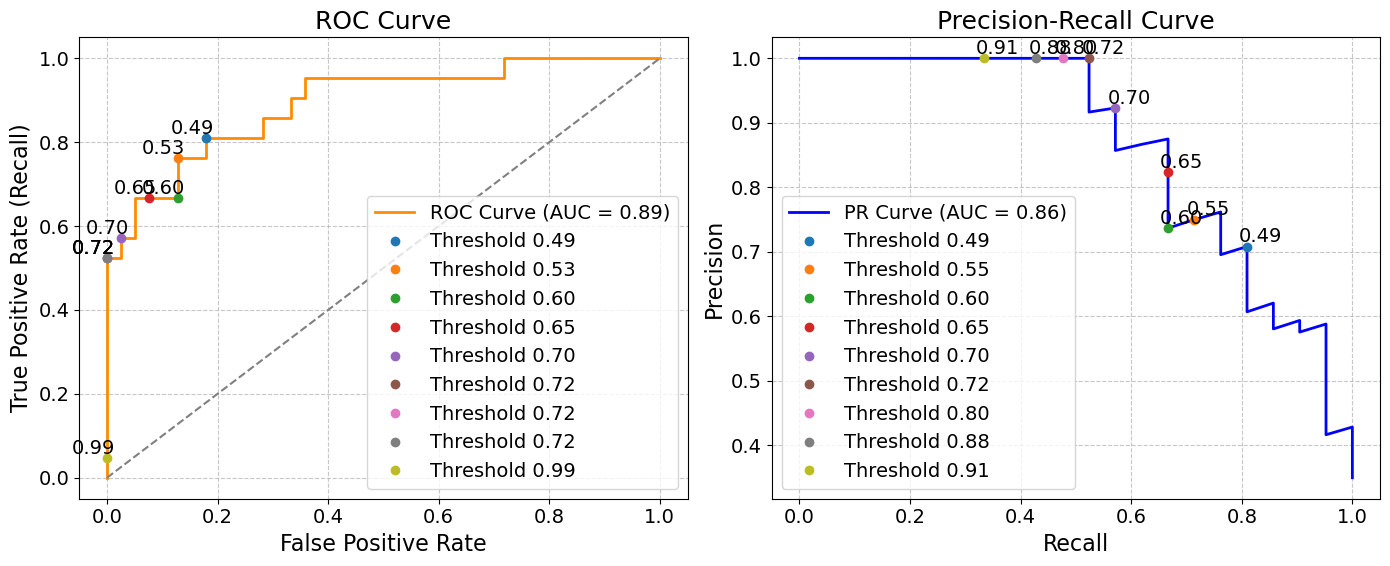

In [24]:
y_scores = result_thresholds['prob_disagree']
y_true = result_thresholds['majority_label'].apply(lambda x: 1 if x == 'disagree' else 0).values

plot_roc_pr_curves(y_true, y_scores, annotator = "Annotator Majority")


In [67]:
result_thresholds["predictions_ft_0.5"].value_counts()

predictions_ft_0.5
no_disagreement    37
disagree           23
Name: count, dtype: int64

In [66]:
result_thresholds["predictions_ft_0.55"].value_counts()

predictions_ft_0.55
no_disagreement    40
disagree           20
Name: count, dtype: int64

In [65]:
result_thresholds["predictions_ft_0.6"].value_counts()

predictions_ft_0.6
no_disagreement    41
disagree           19
Name: count, dtype: int64

In [64]:
result_thresholds["predictions_ft_0.65"].value_counts()

predictions_ft_0.65
no_disagreement    44
disagree           16
Name: count, dtype: int64

In [28]:
def print_cm(axis, df, true_col, pred_col, title):
    print(df[true_col].value_counts())
    
    cm = confusion_matrix(df[true_col], df[pred_col])
    labels = sorted(set(df[true_col]).union(set(df[pred_col])))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axis)
    
    axis.set_xlabel("Predicted Labels")
    axis.set_ylabel("True Labels")
    axis.set_title(title)

majority_label
no_disagreement    39
disagree           21
Name: count, dtype: int64


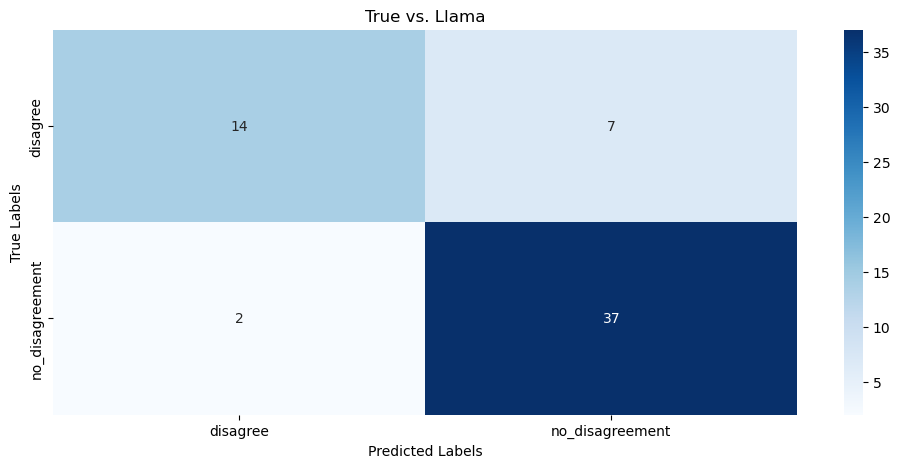

In [29]:

fig, axes = plt.subplots(1, 1, figsize=(12, 5))  


print_cm(
    axis=axes,
    df = result_thresholds,
    true_col = "majority_label",
    pred_col = "predictions_ft_0.65",
    title='True vs. Llama'
)

## **Bootstrapping on the Errors**

In [25]:
label_dict_reverse = {"disagree" : 1, "no_disagreement" : 0}

true_labels = result_thresholds["majority_label"]#.apply(lambda x:label_dict_reverse[x])       # length 60
predicted_labels = result_thresholds["predictions_ft_0.65"]#.apply(lambda x:label_dict_reverse[x])  # length 60
predicted_labels



0     no_disagreement
1     no_disagreement
2     no_disagreement
3     no_disagreement
4     no_disagreement
5     no_disagreement
6            disagree
7     no_disagreement
8            disagree
9     no_disagreement
10    no_disagreement
11    no_disagreement
12           disagree
13    no_disagreement
14           disagree
15    no_disagreement
16    no_disagreement
17    no_disagreement
18    no_disagreement
19    no_disagreement
20    no_disagreement
21    no_disagreement
22    no_disagreement
23    no_disagreement
24    no_disagreement
25           disagree
26    no_disagreement
27           disagree
28    no_disagreement
29    no_disagreement
30           disagree
31           disagree
32    no_disagreement
33    no_disagreement
34           disagree
35    no_disagreement
36    no_disagreement
37    no_disagreement
38    no_disagreement
39           disagree
40           disagree
41    no_disagreement
42           disagree
43    no_disagreement
44           disagree
45    no_d

In [33]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_scores = []
n_iterations = 1000
labels = ["disagree", "no_disagreement"]

precision_scores = {label: [] for label in labels}
recall_scores = {label: [] for label in labels}
f1_scores = {label: [] for label in labels}

# Bootstrap
for _ in range(n_iterations):
    indices = np.random.choice(len(true_labels), size=len(true_labels), replace=True)
    true_sample = [true_labels[i] for i in indices]
    pred_sample = [predicted_labels[i] for i in indices]

    p = precision_score(true_sample, pred_sample, average=None, labels=labels, zero_division=0)
    r = recall_score(true_sample, pred_sample, average=None, labels=labels, zero_division=0)
    f = f1_score(true_sample, pred_sample, average=None, labels=labels, zero_division=0)
    
    b = balanced_accuracy_score(true_sample, pred_sample)
    balanced_accuracy_scores.append(b)

    for i, label in enumerate(labels):
        precision_scores[label].append(p[i])
        recall_scores[label].append(r[i])
        f1_scores[label].append(f[i])

# Og values
original_precision = precision_score(true_labels, predicted_labels, average=None, labels=labels, zero_division=0)
original_recall = recall_score(true_labels, predicted_labels, average=None, labels=labels, zero_division=0)
original_f1 = f1_score(true_labels, predicted_labels, average=None, labels=labels, zero_division=0)

# CI function
def conf_interval(data, alpha=0.05):
    lower = np.percentile(data, 100 * (alpha / 2))
    upper = np.percentile(data, 100 * (1 - alpha / 2))
    return lower, upper

# compute
precision_ci = {label: conf_interval(precision_scores[label]) for label in labels}
recall_ci = {label: conf_interval(recall_scores[label]) for label in labels}
f1_ci = {label: conf_interval(f1_scores[label]) for label in labels}




print(precision_ci)
print(recall_ci)
print(f1_ci)

balanced_accuracy_ci = conf_interval(balanced_accuracy_scores)
original_balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)

print("Balanced Accuracy CI:", balanced_accuracy_ci)
print("Original Balanced Accuracy:", original_balanced_accuracy)

{'disagree': (0.6666666666666666, 1.0), 'no_disagreement': (0.7333333333333333, 0.944517543859649)}
{'disagree': (0.45443181818181816, 0.875), 'no_disagreement': (0.8666216216216217, 1.0)}
{'disagree': (0.571205357142857, 0.9), 'no_disagreement': (0.8192497261774369, 0.9555797101449276)}
Balanced Accuracy CI: (0.6888888888888889, 0.920015873015873)
Original Balanced Accuracy: 0.8076923076923077


In [27]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.65', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[14  7]
 [ 2 37]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.88      0.67      0.76        21
no_disagreement       0.84      0.95      0.89        39

       accuracy                           0.85        60
      macro avg       0.86      0.81      0.82        60
   weighted avg       0.85      0.85      0.84        60

Balanced Accuracy Score: 0.8076923076923077
Accuracy Score: 0.85


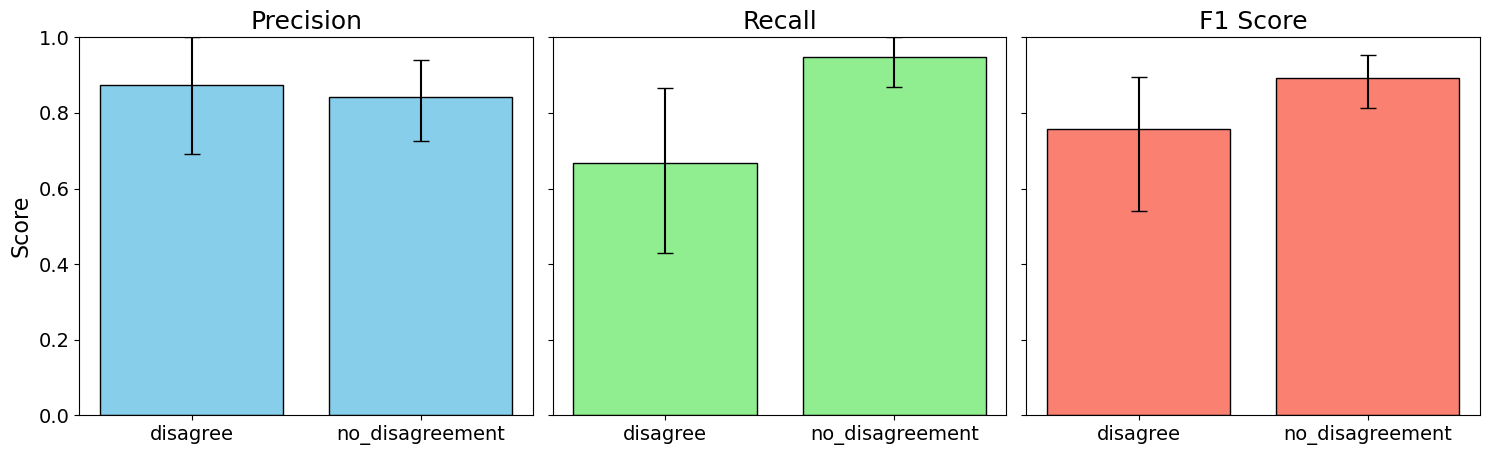

In [32]:
def get_error_bars(orig_scores, cis, labels):
    lowers = [orig_scores[i] - cis[label][0] for i, label in enumerate(labels)]
    uppers = [cis[label][1] - orig_scores[i] for i, label in enumerate(labels)]
    return [lowers, uppers]

# Error bars
precision_error = get_error_bars(original_precision, precision_ci, labels)
recall_error = get_error_bars(original_recall, recall_ci, labels)
f1_error = get_error_bars(original_f1, f1_ci, labels)

# Font size settings
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# --- Precision ---
axes[0].bar(labels, original_precision, yerr=precision_error, capsize=6, color='skyblue', edgecolor='black')
axes[0].set_title("Precision", fontsize=title_fontsize)
axes[0].set_ylabel("Score", fontsize=label_fontsize)
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)

# --- Recall ---
axes[1].bar(labels, original_recall, yerr=recall_error, capsize=6, color='lightgreen', edgecolor='black')
axes[1].set_title("Recall", fontsize=title_fontsize)
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

# --- F1 Score ---
axes[2].bar(labels, original_f1, yerr=f1_error, capsize=6, color='salmon', edgecolor='black')
axes[2].set_title("F1 Score", fontsize=title_fontsize)
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis='both', labelsize=tick_fontsize)

# Overall title
#fig.suptitle("Model Performance per Label (95% Confidence Intervals)", fontsize=title_fontsize)

# Layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("plots/model_metrics_per_label.pdf", bbox_inches='tight')
plt.show()
